In [1]:
import os
import random
import re
import jieba
import warnings
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import numpy as np
# from keras.optimizer_v2.nadam import Nadam
# from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
# from keras.models import Sequential
# from keras.layers import *
# from keras.optimizers import *
# from keras.utils import plot_model
# from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import pandas as pd

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

### 调整超参数

In [3]:
my_lr = 1e-2
my_test_size = 0.2
my_validation_split = 0.1
my_epochs = 100
my_batch_size = 128
my_dropout = 0.2

# my_optimizer = Nadam(lr=my_lr)
my_loss = 'binary_crossentropy'
my_loss1 = 'mse'

### part-A: 数据探索

In [4]:
train_text = pd.read_csv(r'标注2万条.csv',encoding = 'utf-8')

#### 随机展示

In [5]:
train_text.head()

,用户名,博主id,链接,是否含有视频,转发数,评论数,点赞数,微博认证类型,是否原创,性别,博文,发布时间,is_gov,information,emotion
0,梦想水逆退散我可以,5138543056,http://weibo.com/5138543056/InnknF2BA?refer_fl...,0,0,0,0,-1,0,女,2019年的最后一天， 武汉不明原因肺炎引恐慌[嘘]，附近口罩全被抢光了[泪]只能和fzj去...,2020-01-01 00:00:33,no,0.529412,0.470588
1,土豆薯条i,2797789061,http://weibo.com/2797789061/Innkq0sVP?refer_fl...,0,0,0,0,-1,1,男,你许的什么愿呢\n我们改成祝武汉同胞一切安好吧#跨年##武汉发现不明原因肺炎# ​,2020-01-01 00:00:34,no,0.666667,0.333333
2,接着说的吴西,5994769461,http://weibo.com/5994769461/InnkAF4mp?refer_fl...,0,0,0,0,-1,1,男,http://t.cn/AiFuZtRT\n“困”字当选2019海峡两岸年度汉字http:/...,2020-01-01 00:01:04,no,0.800000,0.200000
3,满炯月轮,6424392212,http://weibo.com/6424392212/InnkDCq1V?refer_fl...,0,0,0,0,-1,1,男,#武汉发现不明原因肺炎#牵手时，即使男人的手有多汗，也别放开。 ​,2020-01-01 00:01:11,no,1.000000,0.000000
4,挤痘痘大王,2255435330,http://weibo.com/2255435330/InnkMs47r?refer_fl...,0,0,1,2,-1,1,女,跟欢等公交，发现旁边人都带了口罩排着长队，我俩插在了中间，我还说他们防范意识太强了吧，武汉的...,2020-01-01 00:01:32,no,0.714286,0.285714


In [6]:
text_train = train_text.iloc[:,10]
label_train = train_text.iloc[:,14]
print(text_train .head())
print(label_train.head())

0    2019年的最后一天， 武汉不明原因肺炎引恐慌[嘘]，附近口罩全被抢光了[泪]只能和fzj去...
1           你许的什么愿呢\n我们改成祝武汉同胞一切安好吧#跨年##武汉发现不明原因肺炎#  ​
2    http://t.cn/AiFuZtRT\n“困”字当选2019海峡两岸年度汉字http:/...
3                    #武汉发现不明原因肺炎#牵手时，即使男人的手有多汗，也别放开。 ​
4    跟欢等公交，发现旁边人都带了口罩排着长队，我俩插在了中间，我还说他们防范意识太强了吧，武汉的...
Name: 博文, dtype: object
0    0.470588
1    0.333333
2    0.200000
3    0.000000
4    0.285714
Name: emotion, dtype: float64


#### 数据预处理-分词

In [7]:
cn_model = KeyedVectors.load_word2vec_format('sgns.weibo.bigram.bz2', binary=False)

#### 用jieba分词

In [8]:
sentence = " asdlkzm./.\\t .\n                2"
sentence = sentence.strip("\n")
sentence = sentence.strip("\\t")
sentence = sentence.strip()
print(sentence)

asdlkzm./.\t .
                2


In [9]:
train_tokens = []
for text in text_train:
    # 分词前去掉标点和特殊符号
    text = re.sub("[\s+\.\!\/_,-|$%^*(+\"\')]+|[+——！，； 。？ 、~@#￥%……&*（）]+", "", text)
    # text = text.split()
    cut = jieba.cut(text)
    cut_list = [i for i in cut]
    for i, word in enumerate(cut_list):
        try:
            # 将分出来的每个词转换为词向量中的对应索引
            cut_list[i] = cn_model.key_to_index[word]
        except KeyError:
            # 如果词不在词向量中，则索引标记为0
            cut_list[i] = 0
    train_tokens.append(cut_list)
print('num of train_tokens: {0}'.format(len(train_tokens)))

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\Shy0418\AppData\Local\Temp\jieba.cache
Loading model cost 1.623 seconds.
Prefix dict has been built successfully.


num of train_tokens: 19994


In [10]:
print(train_tokens[0:5])

[[48, 1, 254, 0, 1731, 9353, 1096, 38274, 6728, 15652, 20045, 1136, 6758, 418, 89, 30973, 5, 3586, 579, 16, 33, 446, 0, 6758, 18, 24794, 13, 15780, 0, 5, 845, 3182, 29150, 20045, 40198, 219, 50764, 5, 1354, 1, 254, 0, 23, 140950, 92, 49, 3586, 6102, 7688, 0, 966, 3017, 69, 1, 25, 1182, 0, 16300, 15, 2900, 218, 645, 49, 3177, 40198, 2626, 2931, 225, 3885, 14, 16, 173112, 130, 0, 191, 160, 59, 192, 14, 75, 76, 252, 75, 14, 18, 0], [0, 1, 86, 954, 98, 26, 6401, 638, 1731, 6051, 456, 7612, 49, 3070, 48, 1731, 259, 9353, 1096, 38274, 0], [21, 2746, 30, 625, 14211, 20637, 1496, 11619, 0, 38090, 0, 1731, 0, 12522, 6607, 38274, 41780, 7, 9938, 591, 8, 69842, 38274, 971, 259, 20, 20354, 3528, 16403, 1, 48, 5103, 138703, 4864, 178, 6669, 67, 6030, 21, 2579, 30, 625, 14211, 48, 21, 16184, 1496, 11619, 30, 725, 51, 18614, 27, 2229, 9983, 0, 352, 13, 1181, 16530, 21, 97601, 30, 403, 33420, 13561, 60535, 11619, 4274, 0, 1002, 846, 36, 192, 22, 13561, 43545, 1, 24809], [1731, 259, 9353, 1096, 38274, 

In [11]:
train_tokens1 = pd.DataFrame(train_tokens)
print(train_tokens1.shape)

(19994, 2323)


#### 数据预处理-索引化

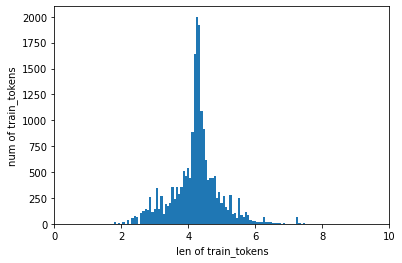

In [12]:
# 获得每条评论的长度，即分词后词语的个数，并将列表转换为ndarray格式
num_tokens = [len(tokens) for tokens in train_tokens]
num_tokens = np.array(num_tokens)

# print('max-len of train_tokens: {0}'.format(np.max(num_tokens)))  # 最长评价的长度 1438
# print('mean-len of train_tokens: {0}'.format(np.mean(num_tokens)))  # 平均评论的长度 68.77625

# 绘制评论长度直方图
plt.hist(np.log(num_tokens), bins = 100)
plt.xlim((0,10))
plt.ylabel('num of train_tokens')
plt.xlabel('len of train_tokens')
plt.show()

# 每段评语的长度不一，需要将索引长度标准化
mid_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
mid_tokens = int(mid_tokens)
rate = np.sum( num_tokens < mid_tokens ) / len(num_tokens)


In [44]:
print('selected mid-len of train_tokens: {0}'.format(mid_tokens)) # 选取一个平均值，尽可能多的覆盖
print('cover rate: {0}'.format(rate)) # 覆盖率

selected mid-len of train_tokens: 332
cover rate: 0.9795438631589477


#### 数据预处理-重新构建词向量

In [13]:
# 为了节省训练时间，抽取前50000个词构建新的词向量
num_words = 50000
embedding_dim = 300

# 初始化embedding_matrix，之后在keras上进行应用
# embedding_matrix为一个 [num_words，embedding_dim] 的矩阵，维度为 50000 * 300
embedding_matrix = np.zeros((num_words, embedding_dim))
for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index_to_key[i]]
embedding_matrix = embedding_matrix.astype('float32')


In [14]:
# 检查新构建的词向量与预训练的词向量index是否对应
print(cn_model[cn_model.index_to_key[10]])
print(embedding_matrix[10])
np.sum(cn_model[cn_model.index_to_key[10]] == embedding_matrix[10] ) # 300

[-2.073660e-01 -3.877230e-01 -5.941960e-01  1.036712e+00 -9.219520e-01
 -2.028490e-01 -1.385460e-01  4.497960e-01  6.371860e-01 -7.204020e-01
  2.503440e-01 -7.094190e-01 -5.069170e-01 -5.819260e-01  5.987460e-01
 -2.300650e-01 -2.411320e-01 -6.163150e-01 -3.919050e-01  3.336300e-02
  7.183510e-01  5.609300e-02  9.089500e-02 -4.454610e-01 -3.104360e-01
  2.306270e-01  1.097352e+00  5.977320e-01  3.648740e-01 -6.742300e-01
  4.962420e-01  5.314670e-01 -1.118670e-01 -1.339079e+00  1.852600e-02
 -7.975500e-02 -4.758900e-02  3.982080e-01  7.224150e-01 -5.032290e-01
 -1.321270e-01 -1.449377e+00 -1.015189e+00  5.312600e-01  1.252450e-01
  6.579160e-01 -3.334980e-01  4.766630e-01 -1.637080e-01  9.153660e-01
  5.176910e-01  6.078030e-01 -3.126110e-01  2.178230e-01  8.761300e-02
 -2.659590e-01  5.893190e-01  9.001680e-01 -9.469720e-01  5.549240e-01
 -5.841270e-01 -1.486187e+00 -4.161990e-01  4.835240e-01  1.306750e-01
 -2.715700e-02 -2.704730e-01 -6.831700e-02  1.389320e-01  2.713860e-01
 -2.83

300

In [15]:
# 新建词向量的维度，keras会用到
embedding_matrix.shape

(50000, 300)

 #### 数据预处理-填充与裁剪

In [16]:
from keras_preprocessing.sequence import pad_sequences

# 输入的train_tokens是一个list，返回的train_pad是一个numpy array，采用pre填充的方式
train_pad = pad_sequences(train_tokens, maxlen=mid_tokens, padding='pre', truncating='pre')
print(train_pad)

[[    0     0     0 ...    14    18     0]
 [    0     0     0 ...  1096 38274     0]
 [    0     0     0 ... 43545     1 24809]
 ...
 [    0     0     0 ...  3863   667   217]
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]]


In [17]:
# 超出五万个词向量的词用0代替
train_pad[train_pad>=num_words] = 0

# 准备实际输出结果向量向量，前2000好评的样本设为1，后2000差评样本设为0
train_target = label_train
print(train_target)

0        0.470588
1        0.333333
2        0.200000
3        0.000000
4        0.285714
           ...   
19989    0.052632
19990    0.125000
19991    0.050000
19992    0.000000
19993    0.000000
Name: emotion, Length: 19994, dtype: float64


#### 训练

In [18]:
X_train, X_test, y_train, y_test = train_test_split(train_pad, train_target, test_size=0.2, random_state=12,shuffle=True)

In [19]:
# print(y_train)
# print(X_train)
print(X_train.shape)
print(y_train.shape)

(15995, 332)
(15995,)


#### 存储编码后的文件

In [20]:
pd.DataFrame(X_train).to_csv(r'x_train_weight.csv',encoding='utf-8',index=False)

#### 搭建神经网络

In [21]:

from tensorflow_core.python.keras.layers import Flatten
import  numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import  Sequential,layers,utils,losses
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard
from tensorflow.keras.layers import Dense,Input,Dropout,Embedding,LSTM,Bidirectional
import  warnings
warnings.filterwarnings('ignore')



model = Sequential()
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=mid_tokens, trainable=False))
# model.add(Embedding(num_words, embedding_dim, input_shape=[,X_train.shape], input_length=mid_tokens, trainable=False))
model.add(Bidirectional(LSTM(units=64, dropout=0.4, return_sequences=True)))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [22]:
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

#### 查看模型结构

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 332, 300)          15000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 332, 128)          186880    
_________________________________________________________________
flatten (Flatten)            (None, 42496)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               10879232  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 26,066,369
Trainable params: 11,066,369
Non-trainable params: 15,000,000
_________________________________________________________________


#### 调试

In [24]:
path_checkpoint = 'weights.hdf5'
checkpointer = ModelCheckpoint(filepath=path_checkpoint,monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=True)

#### 尝试加载已训练模型

In [25]:

# try:
#     model.load_weights(path_checkpoint)
# except Exception as e:
#     print(e)

#### 定义early stoping如果10个epoch内validation loss没有改善则停止训练

In [26]:

from tensorflow_core.python.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [27]:
from tensorflow_core.python.keras.callbacks import ReduceLROnPlateau

# 自动降低learning rate
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=1e-5, patience=0, verbose=1)


#### 定义callback函数

In [28]:
callbacks = [earlystopping, checkpointer, lr_reduction]

#### 变换形状,输入网络中

In [29]:
# X_train = np.array(X_train)
# X_train.reshape(X_train.shape[0],1,X_train.shape[1])
# y_train = np.array(y_train)
# y_train.reshape(y_train.shape[0],1,y_train.shape[1])

In [30]:
X_train1 = pd.read_csv(r'x_train_weight.csv',encoding='utf-8',header=1).fillna(0).astype(float).values
print(X_train1.shape)
# print(X_train1.head())

(15994, 332)


In [31]:
# 开始训练
history = model.fit(X_train, y_train, validation_split=my_validation_split, epochs = 60, batch_size=my_batch_size, callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 14395 samples, validate on 1600 samples
Epoch 1/60
14336/14395 [============================>.] - ETA: 1s - loss: 0.0428 - acc: 0.2135
Epoch 00001: val_loss improved from inf to 0.04222, saving model to weights.hdf5
14395/14395 [==============================] - 433s 30ms/sample - loss: 0.0428 - acc: 0.2133 - val_loss: 0.0422 - val_acc: 0.2019
Epoch 2/60
14336/14395 [============================>.] - ETA: 1s - loss: 0.0420 - acc: 0.2144
Epoch 00002: val_loss did not improve from 0.04222

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
14395/14395 [==============================] - 424s 29ms/sample - loss: 0.0419 - acc: 0.2143 - val_loss: 0.0422 - val_acc: 0.2019
Epoch 3/60
14336/14395 [============================>.] - ETA: 1s - loss: 0.0419 - acc: 0.2138
Epoch 00003: val_loss did not improve from 0.04222

Epoch 00003: ReduceLROnPlateau reducing learni

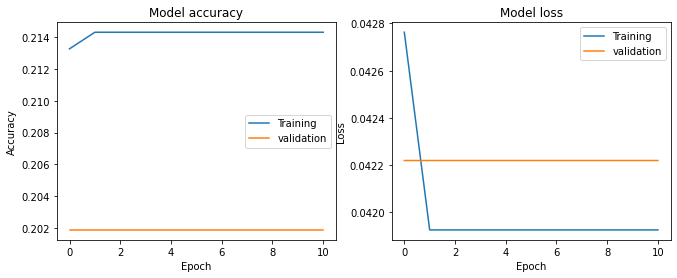

InvocationException: GraphViz's executables not found

In [32]:
from tensorflow_core.python.keras.utils import plot_model

# 模型可视化-历史
plt.figure(figsize=(11, 4))

plt.figure(1)
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'validation'])

plt.figure(1)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'validation'])

plt.show()

# 模型可视化-RNN
plot_model(model, show_shapes=True, show_layer_names=True, to_file='tmp\\model.png')

### 模型评估

In [36]:

# 模型评估-准确率
result = model.evaluate(X_train, y_train, verbose=0)
print('Loss: {0:.4}'.format(result[0]))
print('Accuracy: {0:.4%}'.format(result[1]))

Loss: 0.04196
Accuracy: 21.3067%


In [37]:
import pandas as pd

test_text = pd.read_csv(r'1月_add_gov.csv',encoding='utf-8',index_col='博主id')
test_text.head()

,链接,是否含有视频,转发数,评论数,点赞数,微博认证类型,是否原创,性别,博文,发布时间,is_gov
博主id,,,,,,,,,,,
1978054071,http://weibo.com/1978054071/Is4iA2gG1?refer_fl...,0,0,0,0,1,0,女,#战胜新型冠状病毒#宁夏应对新型冠状病毒感染肺炎疫情工作指挥部公告（第三号）####战胜新型...,2020-01-31 20:45:27,yes
2279982780,http://weibo.com/2279982780/Is01jyQIv?refer_fl...,0,0,1,1,1,0,男,关于新型冠状病毒感染的肺炎，这些谣言你别信！#战胜新型冠状病毒# ​​​###关于新型冠状病...,2020-01-31 09:51:55,yes
2062204527,http://weibo.com/2062204527/IrZt9rt6G?refer_fl...,0,1,0,0,1,0,男,关于新型冠状病毒感染的肺炎，这些谣言你别信！#战胜新型冠状病毒# ​​​###关于新型冠状病...,2020-01-31 08:27:45,yes
2137821047,http://weibo.com/2137821047/Is4hbqMtg?refer_fl...,0,0,0,0,1,0,男,#战胜新型冠状病毒#宁夏应对新型冠状病毒感染肺炎疫情工作指挥部公告（第三号）####战胜新型...,2020-01-31 20:42:01,yes
1978054071,http://weibo.com/1978054071/Is0orfI0u?refer_fl...,0,1,0,0,1,0,女,#战胜新型冠状病毒# 全区新型冠状病毒感染的肺炎疫情通报####战胜新型冠状病毒# 全区新型...,2020-01-31 10:48:53,yes


In [38]:
test_text1 = test_text.iloc[:,8]
print(test_text1[0:10])

博主id
1978054071    #战胜新型冠状病毒#宁夏应对新型冠状病毒感染肺炎疫情工作指挥部公告（第三号）####战胜新型...
2279982780    关于新型冠状病毒感染的肺炎，这些谣言你别信！#战胜新型冠状病毒# ​​​###关于新型冠状病...
2062204527    关于新型冠状病毒感染的肺炎，这些谣言你别信！#战胜新型冠状病毒# ​​​###关于新型冠状病...
2137821047    #战胜新型冠状病毒#宁夏应对新型冠状病毒感染肺炎疫情工作指挥部公告（第三号）####战胜新型...
1978054071    #战胜新型冠状病毒# 全区新型冠状病毒感染的肺炎疫情通报####战胜新型冠状病毒# 全区新型...
1933890202    #战胜新型冠状病毒# 全区新型冠状病毒感染的肺炎疫情通报####战胜新型冠状病毒# 全区新型...
5385428953               #新型冠状病毒# 新型冠状病毒感染的肺炎公众防护指南。 O网页链接 ​​​​
1885504473                关于新型冠状病毒感染的肺炎，这些谣言你别信！#战胜新型冠状病毒# ​​​​
2675070131            实时更新 | 新型冠状病毒肺炎全国疫情地图 O新型冠状病毒肺炎全国疫情图 ​​​​
5657460977    我省新增36例新型冠状病毒感染的肺炎确诊病例 1月30日，按照《新型冠状病毒感染的肺炎诊疗方...
Name: 博文, dtype: object


### 测试集预处理并编码
#### jieba分词

In [39]:
print(test_text1.shape)

(2591840,)


In [40]:
test_tokens = []
for text in test_text1:
    # 分词前去掉标点和特殊符号
    text = re.sub("[\s+\.\!\/_,-|$%^*(+\"\')]+|[+——！，； 。？ 、~@#￥%……&*（）]+", "", str(text))
    # text = text.split()
    cut = jieba.cut(text)
    cut_list = [i for i in cut]
    for i, word in enumerate(cut_list):
        try:
            # 将分出来的每个词转换为词向量中的对应索引
            cut_list[i] = cn_model.key_to_index[word]
        except KeyError:
            # 如果词不在词向量中，则索引标记为0
            cut_list[i] = 0
    test_tokens.append(cut_list)
print('num of train_tokens: {0}'.format(len(test_tokens)))

num of train_tokens: 2591840


#### 保存

In [43]:
# pd.DataFrame(test_tokens).to_csv(r'测试集分词结果.csv',encoding='utf-8')
print(test_tokens[0:5])

[[7048, 9850, 129767, 3364, 5554, 9850, 129767, 5958, 38274, 41780, 246, 38360, 9101, 0, 7048, 9850, 129767, 3364, 5554, 9850, 129767, 5958, 38274, 41780, 246, 38360, 9101, 0, 3364, 5554, 9850, 129767, 5958, 38274, 41780, 246, 38360, 0, 0, 0, 0], [911, 9850, 129767, 5958, 1, 38274, 313, 6330, 15, 0, 7048, 9850, 129767, 0, 0, 0, 911, 9850, 129767, 5958, 1, 38274, 313, 6330, 15, 0, 7048, 9850, 129767, 0, 0, 0, 0], [911, 9850, 129767, 5958, 1, 38274, 313, 6330, 15, 0, 7048, 9850, 129767, 0, 0, 0, 911, 9850, 129767, 5958, 1, 38274, 313, 6330, 15, 0, 7048, 9850, 129767, 0, 0, 0, 0], [7048, 9850, 129767, 3364, 5554, 9850, 129767, 5958, 38274, 41780, 246, 38360, 9101, 0, 7048, 9850, 129767, 3364, 5554, 9850, 129767, 5958, 38274, 41780, 246, 38360, 9101, 0, 0], [7048, 9850, 129767, 50522, 9850, 129767, 5958, 1, 38274, 41780, 12522, 7048, 9850, 129767, 50522, 9850, 129767, 5958, 1, 38274, 41780, 12522, 5754, 37, 0, 50522, 6230, 2494, 9850, 129767, 5958, 1, 38274, 18244, 19968, 6607, 33087, 6607

In [45]:
from keras_preprocessing.sequence import pad_sequences

# 输入的train_tokens是一个list，返回的train_pad是一个numpy array，采用pre填充的方式
test_pad = pad_sequences(test_tokens, maxlen=mid_tokens, padding='pre', truncating='pre')
print(test_pad)

[[    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 ...
 [    0     0     0 ...     0  3548  6890]
 [    0     0     0 ... 18244  9850 38274]
 [    0     0     0 ... 18244  9850 38274]]


In [46]:
print(test_pad.shape)

(2591840, 332)


In [47]:
# 超出五万个词向量的词用0代替
test_pad[test_pad>=num_words] = 0

# 准备实际输出结果向量向量，前2000好评的样本设为1，后2000差评样本设为0
# test_target = label_train

In [48]:
print(test_pad)

[[    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 ...
 [    0     0     0 ...     0  3548  6890]
 [    0     0     0 ... 18244  9850 38274]
 [    0     0     0 ... 18244  9850 38274]]


### 测试集预测

In [ ]:
predict = model.predict(test_pad,batch_size = my_batch_size,verbose = 0)
print(predict)